In [1]:
from causalimpact import CausalImpact

import numpy as np
import pandas as pd
import datetime
from datetime import datetime

from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters

In [3]:
from statsmodels.tsa.arima_model import ARIMA

In [4]:
import warnings
warnings.filterwarnings("ignore")

# **Data**

In [5]:
data = pd.read_csv("KOEPPEL FUNNEL.csv", parse_dates=['Date'])

In [6]:
print('Time period is: from ', data.Date.min().date(), ' to ', data.Date.max().date())

Time period is: from  2022-03-14  to  2022-10-30


In [7]:
#remove last row: totals
data = data.dropna(how='any', subset=['Date'], axis = 0)

Changing data types

In [8]:
data['tCVR'] = data['tCVR'].str.rstrip("%").astype(float)/100

data['CPT'] = data.CPT.str[1:].astype(str).astype(float)
data['CPI'] = data.CPI.str[1:].astype(str).astype(float)
data['Spend'] = data.Spend.str[1:].str.replace(',', '').astype(str).astype(float)
data['Rate'] = data.Rate.str[1:].astype(str).astype(float)

data['Frequency'] = data['Frequency'].astype(str).astype(int)

data['Trials'] = data['Trials'].astype(str).astype(int)

data['Installs'] = data['Installs'].str.replace(',', '').astype(str).astype(int)

In [9]:
data=data.sort_values(by=['Date'])
#reset indexes
data.reset_index(drop=True, inplace = True)

In [10]:
# Set pre-period
pre_period = [str(data.Date.min())[:10], str('2022-10-19')]
# Set post-period
post_period = [str('2022-10-20'), str(data.Date.max())[:10]]

# **Casual Impact model**

In [11]:
model_data=data[['Date', 'Trials']]
model_data.set_index('Date', inplace=True)

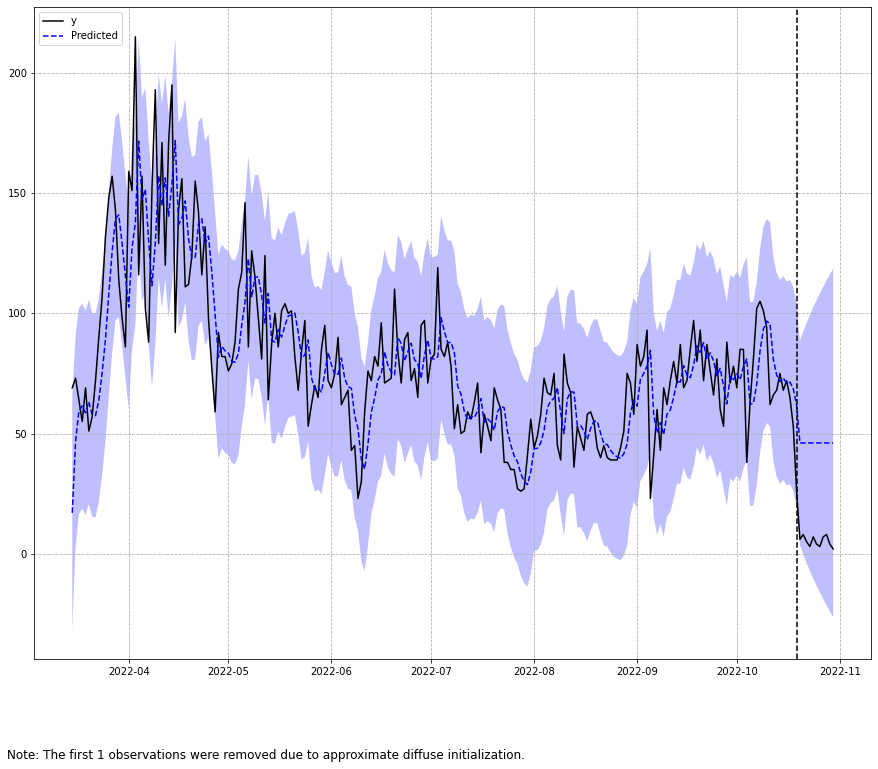

In [12]:
# Causal impact model, prior_level_sd default of 0.01
impact_15 = CausalImpact(data=model_data.Trials, pre_period=pre_period, post_period=post_period, prior_level_sd = None)
impact_15.plot(panels=['original'])

In [13]:
print(impact_15.summary('report'))
#downlift: -49.19
#trials predicted: 598.13

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 5.18. By contrast, in the absence of an
intervention, we would have expected an average response of 46.08.
The 95% interval of this counterfactual prediction is [5.45, 91.14].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -40.9 with a 95% interval of
[-85.96, -0.27]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 57.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 506.86. The 95% interval of this prediction is [59.95, 1002.55].


The above results are given in terms of absolute numbers. In relative
terms, the response variable 

In [14]:
sse = np.sum((impact_15.inferences.preds.loc[model_data.index < '2022-10-20'] - model_data.loc[model_data.index < '2022-10-20','Trials'])**2)
print(sse)

107125.65255394971


In [15]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print('MAE: ', mean_absolute_error( model_data.loc[model_data.index < '2022-10-20','Trials'], impact_15.inferences.preds.loc[model_data.index < '2022-10-20']))
print('MAPE: ',mean_absolute_percentage_error( model_data.loc[model_data.index < '2022-10-20','Trials'], impact_15.inferences.preds.loc[model_data.index < '2022-10-20']))
print('RMSE: ', mean_squared_error(model_data.loc[model_data.index < '2022-10-20','Trials'], impact_15.inferences.preds.loc[model_data.index < '2022-10-20'], squared=False))

MAE:  16.350629173446496
MAPE:  0.23992173445250944
RMSE:  22.06659883933487


In [16]:
impact_15.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                 Trials   No. Observations:                  220
Model:                    local level   Log Likelihood                -215.273
Date:                Mon, 12 Dec 2022   AIC                            434.545
Time:                        14:52:54   BIC                            441.323
Sample:                    03-14-2022   HQIC                           437.283
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.2345      0.022     10.634      0.000       0.191       0.278
sigma2.level         0.0802      0.017      4.706      0.000       0.047       0.114
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):                15.63
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# **ARIMA** time series analysis

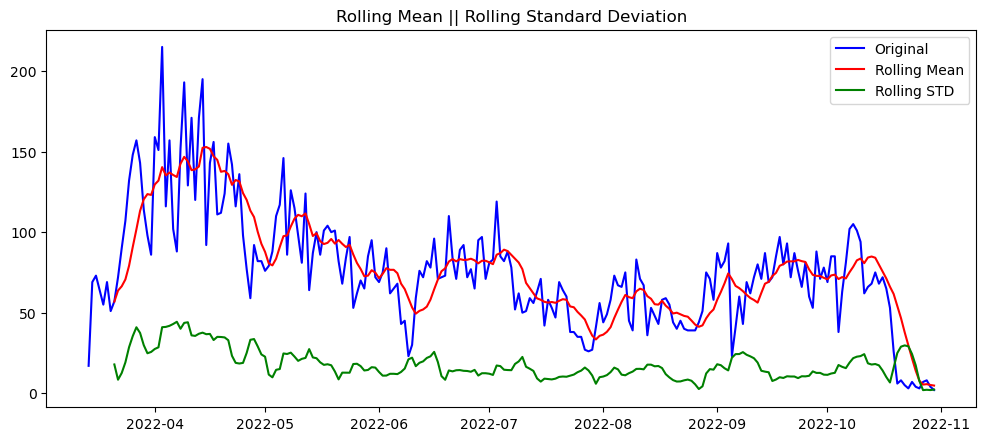

In [17]:
rolling_mean = model_data.rolling(window = 8).mean()
rolling_std = model_data.rolling(window = 8).std()

# ploting the data
plt.figure(figsize=(12,5), dpi=100)
plt.plot(model_data, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'green', label = 'Rolling STD')
plt.legend(loc = 'best')
plt.title('Rolling Mean || Rolling Standard Deviation')
plt.show()

In [18]:
result = adfuller(model_data['Trials'])
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.6803319735368305
P-Values: 0.4412734588178363
Critical Values: 
	1%: -3.460154163751041
	5%: -2.874648939216792
	10%: -2.5737567259151044


Time series is non stationary!

In [19]:
#in one function:

In [20]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Trials'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

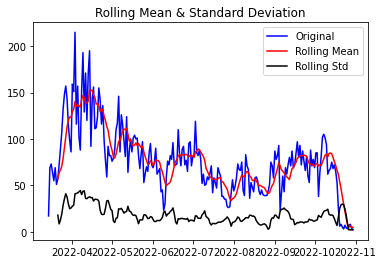

ADF Statistic: -1.6803319735368305
p-value: 0.4412734588178363
Critical Values:
	1%: -3.460154163751041
	5%: -2.874648939216792
	10%: -2.5737567259151044


In [21]:
get_stationarity(model_data)

In [22]:
result = adfuller(model_data['Trials'].diff().dropna())
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -6.185648392816719
P-Values: 6.299035106685484e-08
Critical Values: 
	1%: -3.460154163751041
	5%: -2.874648939216792
	10%: -2.5737567259151044


**Finding model parameters:**

Time series from 1st degree differencing is stationary!

In [23]:
from pmdarima.arima.utils import ndiffs

ndiffs(model_data['Trials'], test='adf')  #1

1

In [24]:
ndiffs(model_data['Trials'], test='kpss')  #1

1

**d=1**

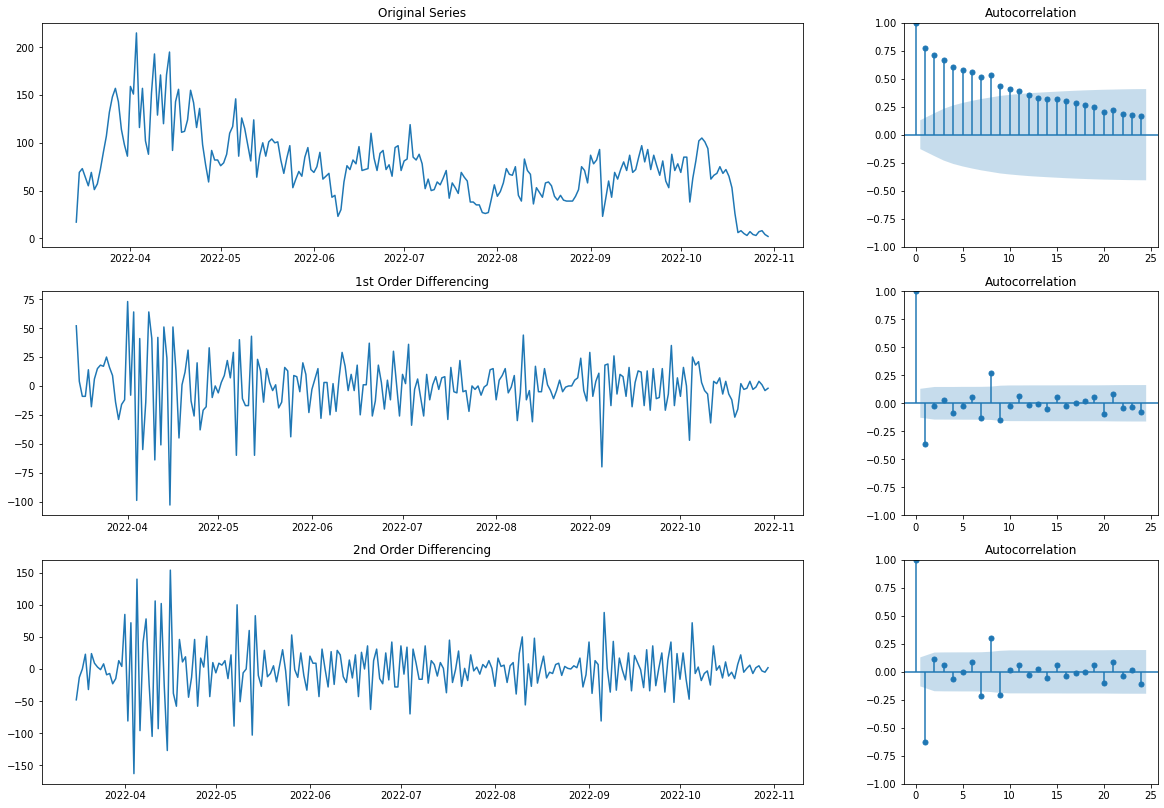

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2,gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 14))
axes[0, 0].plot(model_data['Trials']); axes[0, 0].set_title('Original Series')
plot_acf(model_data['Trials'], ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(model_data['Trials'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(model_data['Trials'].diff().dropna(), ax=axes[1, 1])
# 2nd Differencing
axes[2, 0].plot(model_data['Trials'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(model_data['Trials'].diff().diff().dropna(), ax=axes[2, 1])
plt.show()

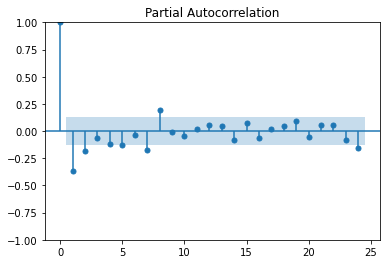

In [26]:
plot_pacf(model_data['Trials'].diff().dropna())
plt.show()

**max(p)=3** (can be set to 2 or 1)

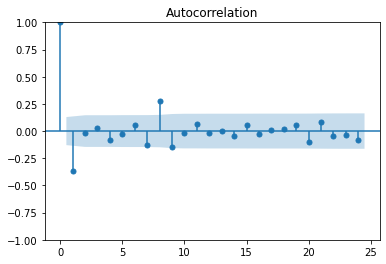

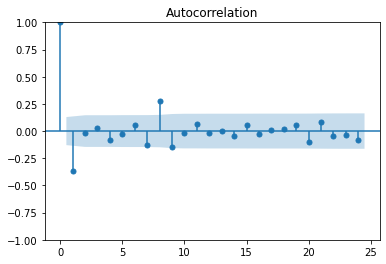

In [27]:
plot_acf(model_data['Trials'].diff().dropna()) 

**max(q)=2** (can be set to 1)

In [28]:
from  statsmodels.tsa.arima.model import ARIMA
# ARIMA order (p,d,q)
model = ARIMA(model_data['Trials'], order=(3,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Trials   No. Observations:                  231
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1029.037
Date:                Mon, 12 Dec 2022   AIC                           2070.073
Time:                        14:52:56   BIC                           2090.702
Sample:                    03-14-2022   HQIC                          2078.394
                         - 10-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1021      1.197     -0.085      0.932      -2.448       2.243
ar.L2          0.1905      0.295      0.645      0.519      -0.389       0.770
ar.L3          0.0781      0.085      0.916      0.3

Train and test for pre and post period:

In [29]:
model_data.shape

(231, 1)

In [30]:
train =  model_data.loc[model_data.index <= '2022-10-19', 'Trials']

In [31]:
train.shape

(220,)

In [32]:
test = model_data.loc[model_data.index > '2022-10-19', 'Trials']

In [33]:
test.shape

(11,)

Auto-ARIMA

In [34]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2020.453, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1974.422, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1974.378, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1975.502, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1975.869, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1977.862, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1988.945, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1973.794, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1975.125, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1976.874, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1977.866, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1982.200, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1975.014, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1976.993, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1978.831, Time=0.26 sec
 ARIMA(3,1

In [35]:
prediction, confint = auto_model.predict(n_periods=11, return_conf_int=True)

prediction

2022-10-20    46.234193
2022-10-21    50.412263
2022-10-22    51.276865
2022-10-23    51.457672
2022-10-24    51.497366
2022-10-25    51.507939
2022-10-26    51.512502
2022-10-27    51.515824
2022-10-28    51.518891
2022-10-29    51.521905
2022-10-30    51.524908
Freq: D, dtype: float64

In [36]:
cf= pd.DataFrame(confint)

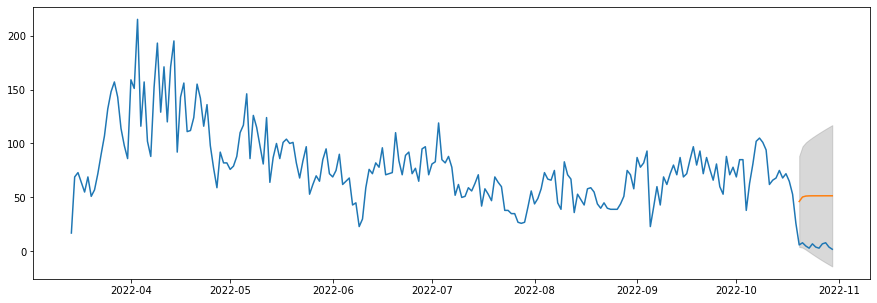

In [37]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(model_data)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

# ARIMA model

In [38]:
import numpy as np
model = ARIMA(train, order=(3,1,2))  
fitted = model.fit()

In [39]:
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                 Trials   No. Observations:                  220
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -982.344
Date:                Mon, 12 Dec 2022   AIC                           1976.688
Time:                        14:52:59   BIC                           1997.022
Sample:                    03-14-2022   HQIC                          1984.900
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0932      1.261     -0.074      0.941      -2.564       2.378
ar.L2          0.1923      0.333      0.578      0.564      -0.460       0.845
ar.L3          0.0763      0.091      0.835      0.4

In [40]:
# Forecast
fc = fitted.forecast(11, alpha=0.05)

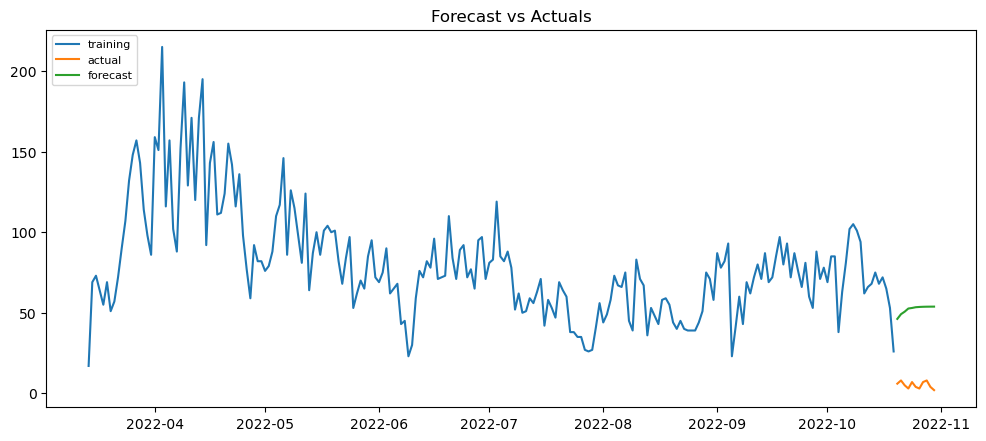

In [41]:
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

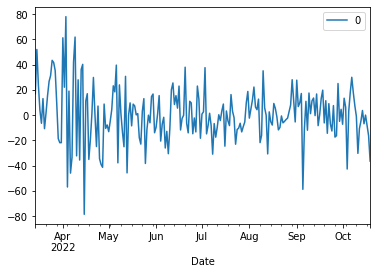

In [42]:
residuals = pd.DataFrame(fitted.resid)
residuals.plot()
plt.show()

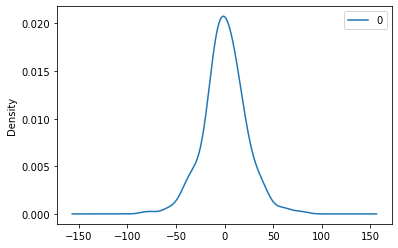

In [43]:
residuals.plot(kind='kde')
plt.show()

In [44]:
print(residuals.describe())

                0
count  220.000000
mean     0.392276
std     21.544322
min    -78.549701
25%    -11.115647
50%      0.251988
75%     12.646478
max     78.004870


# **Casual Impact and ARIMA comparison**

Predicted Price pct change


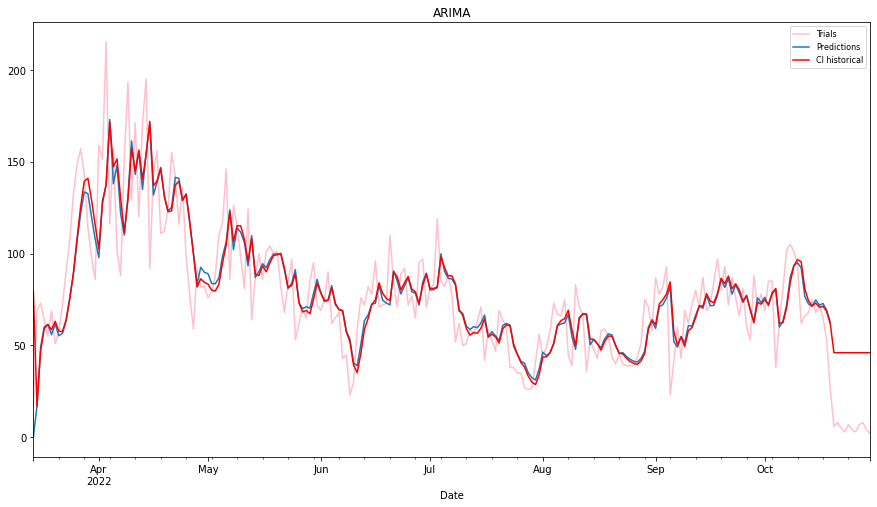

In [45]:
print("Predicted Price pct change")
def plotARMA(df_accumulative,ax, model):
    result=df_accumulative
    mod = model
    res = mod.fit()
    # Plot the original series and the forecasted series
    #res.plot_predict(start=0, end=400)
    df_accumulative.plot(ax=ax,label='Trials', color = 'pink')
    res.predict().plot(ax=ax,label='Predictions')
    plt.plot(impact_15.inferences.preds, color = 'red', label = 'CI historical')

fig,ax = plt.subplots(figsize=(15,8))    
plotARMA(model_data['Trials'],ax, model)
plt.legend(fontsize=8)
plt.title("ARIMA")
plt.show()

ARIMA predictions track Casual Impact model historical estimations

# Predictions if TV spend remains off

Trained on the entire dataset:

In [46]:
# ARIMA order (p,d,q)
model_future = ARIMA(model_data['Trials'], order=(3,1,2))
model_fit_future = model_future.fit()
print(model_fit_future.summary())

                               SARIMAX Results                                
Dep. Variable:                 Trials   No. Observations:                  231
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1029.037
Date:                Mon, 12 Dec 2022   AIC                           2070.073
Time:                        14:53:00   BIC                           2090.702
Sample:                    03-14-2022   HQIC                          2078.394
                         - 10-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1021      1.197     -0.085      0.932      -2.448       2.243
ar.L2          0.1905      0.295      0.645      0.519      -0.389       0.770
ar.L3          0.0781      0.085      0.916      0.3

In [47]:
fc = model_fit_future.forecast(62, alpha=0.05)

In [48]:
from datetime import date, timedelta

sdate = date(2022,10,31) 
edate = date(2023,1,1) 
forecast_index = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

In [49]:
len(forecast_index)

62

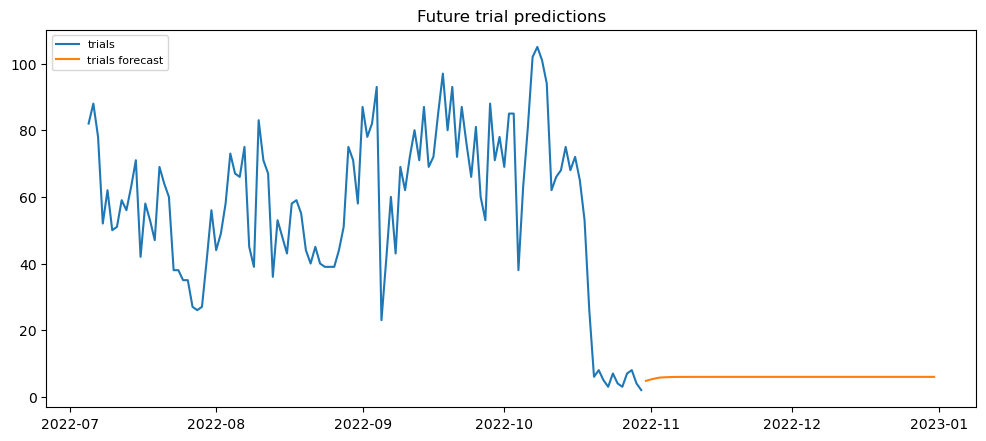

In [50]:
fc_series = pd.Series(fc,forecast_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(model_data.loc[model_data.index > '2022-07-04','Trials'], label='trials')
plt.plot(fc_series, label='trials forecast')
plt.title('Future trial predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()

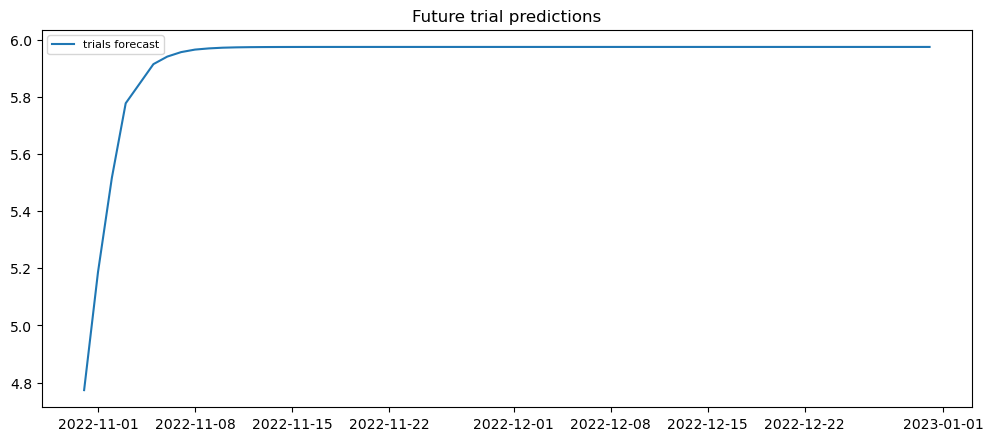

In [51]:
fc_series = pd.Series(fc,forecast_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(model_data.loc[model_data.index > '2022-07-04','Trials'], label='trials')
plt.plot(fc_series, label='trials forecast')
plt.title('Future trial predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [52]:
fc.groupby([lambda x: x.year, lambda x: x.month]).sum()

2022  10      4.773774
      11    177.539966
      12    185.220070
Name: predicted_mean, dtype: float64

Predicted trials for November: 177\
Predicted trials for December: 185

In [53]:
model_data.groupby([lambda x: x.year, lambda x: x.month]).sum()

Trials
Date Date        
2022 3       1602
     4       3896
     5       2822
     6       2172
     7       1796
     8       1674
     9       2176
     10      1435

# Trained only on post period data

In [54]:
# ARIMA order (p,d,q)
model_future_try = ARIMA(model_data.loc[model_data.index >= '2022-10-20','Trials'], order=(3,1,2))
model_fit_future_try = model_future_try.fit()
print(model_fit_future_try.summary())

                               SARIMAX Results                                
Dep. Variable:                 Trials   No. Observations:                   11
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 -19.629
Date:                Mon, 12 Dec 2022   AIC                             51.259
Time:                        14:53:01   BIC                             53.074
Sample:                    10-20-2022   HQIC                            49.267
                         - 10-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9372      3.251     -0.288      0.773      -7.309       5.434
ar.L2         -0.8443      1.279     -0.660      0.509      -3.351       1.662
ar.L3         -0.6173      2.702     -0.228      0.8

In [55]:
fc_try = model_fit_future_try.forecast(62, alpha=0.05)

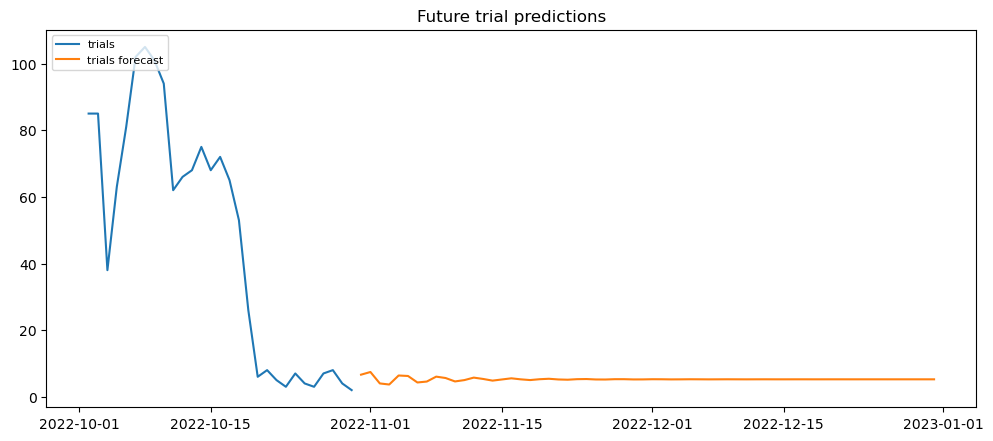

In [56]:
fc_series_try = pd.Series(fc_try,forecast_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(model_data.loc[model_data.index > '2022-10-01','Trials'], label='trials')
plt.plot(fc_series_try, label='trials forecast')
plt.title('Future trial predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Trained only on post period data:

In [57]:
fc_try.groupby([lambda x: x.year, lambda x: x.month]).sum()

2022  10      6.633762
      11    157.831462
      12    162.486929
Name: predicted_mean, dtype: float64

Predicted trials for November: 158\
Predicted trials for December: 162

When trained on all data:

In [58]:
fc.groupby([lambda x: x.year, lambda x: x.month]).sum()

2022  10      4.773774
      11    177.539966
      12    185.220070
Name: predicted_mean, dtype: float64

In [59]:
model_data.groupby([lambda x: x.year, lambda x: x.month]).sum()

Trials
Date Date        
2022 3       1602
     4       3896
     5       2822
     6       2172
     7       1796
     8       1674
     9       2176
     10      1435